# Milestone 2

- Spencer Gerlach, Xinru Lu and Lauren Zung

## 1. Setup your EC2 instance

https://github.com/UBC-MDS/DSCI_525_group_20/blob/main/notebooks/milestone_2/ms2_525_1.png

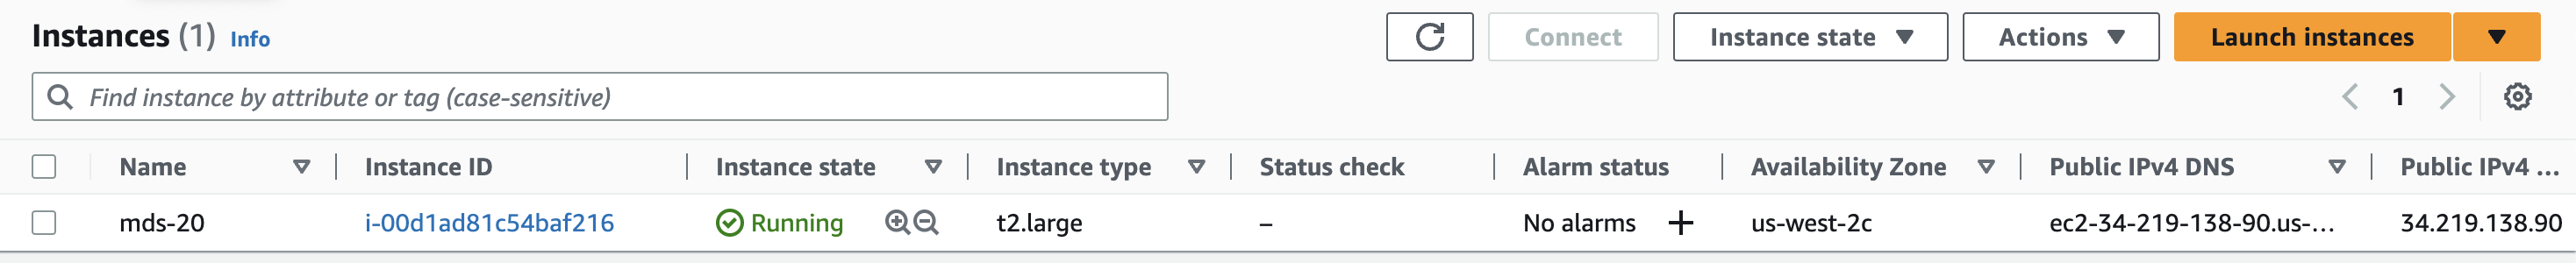

## 2. Setup the server

https://github.com/UBC-MDS/DSCI_525_group_20/blob/main/notebooks/milestone_2/ms2_525_2.png

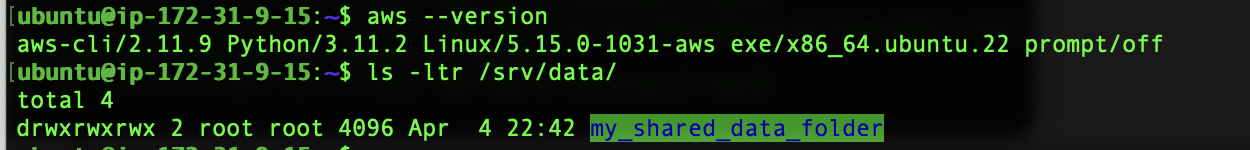

## 3. Setup your JupyterHub

https://github.com/UBC-MDS/DSCI_525_group_20/blob/main/notebooks/milestone_2/ms2_525_3.png

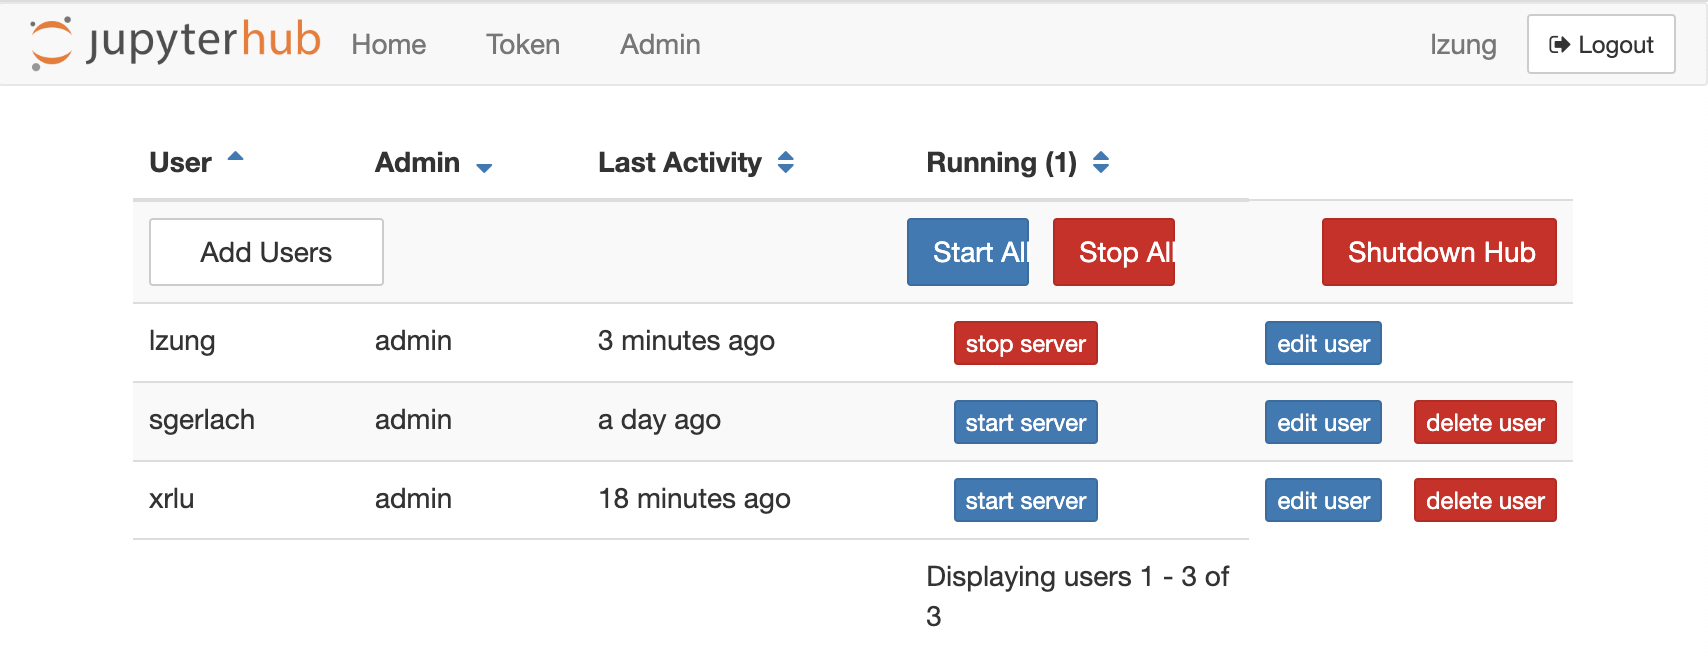

## 4. Get the data that we wrangled in our first milestone

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

In [2]:
# Necessary metadata
article_id = 14226968  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "../../../srv/data/my_shared_data_folder/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

[{'id': 26844650,
  'name': 'allyears.csv.zip',
  'size': 2405908113,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26844650',
  'supplied_md5': '9e046ac05ecd2c32a256a47dd1098b81',
  'computed_md5': '9e046ac05ecd2c32a256a47dd1098b81'},
 {'id': 26863682,
  'name': 'individual_years.zip',
  'size': 1896206676,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26863682',
  'supplied_md5': '921da748974b07b2a70bbfcc04535a77',
  'computed_md5': '921da748974b07b2a70bbfcc04535a77'},
 {'id': 27515426,
  'name': 'combined_model_data.csv.zip',
  'size': 821308997,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/27515426',
  'supplied_md5': '7638434c44a7d29cbb29fe200b4fd65d',
  'computed_md5': '7638434c44a7d29cbb29fe200b4fd65d'},
 {'id': 27520682,
  'name': 'combined_model_data_parti.parquet.zip',
  'size': 519743915,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/

In [4]:
files_to_dl = ["combined_model_data_parti.parquet.zip"]  ## Please download the partitioned 
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

In [5]:
with zipfile.ZipFile(os.path.join(output_directory, "combined_model_data_parti.parquet.zip"), 'r') as f:
    f.extractall(output_directory)

## 5. Setup your S3 bucket and move data

https://github.com/UBC-MDS/DSCI_525_group_20/blob/main/notebooks/milestone_2/ms2_525_4.png

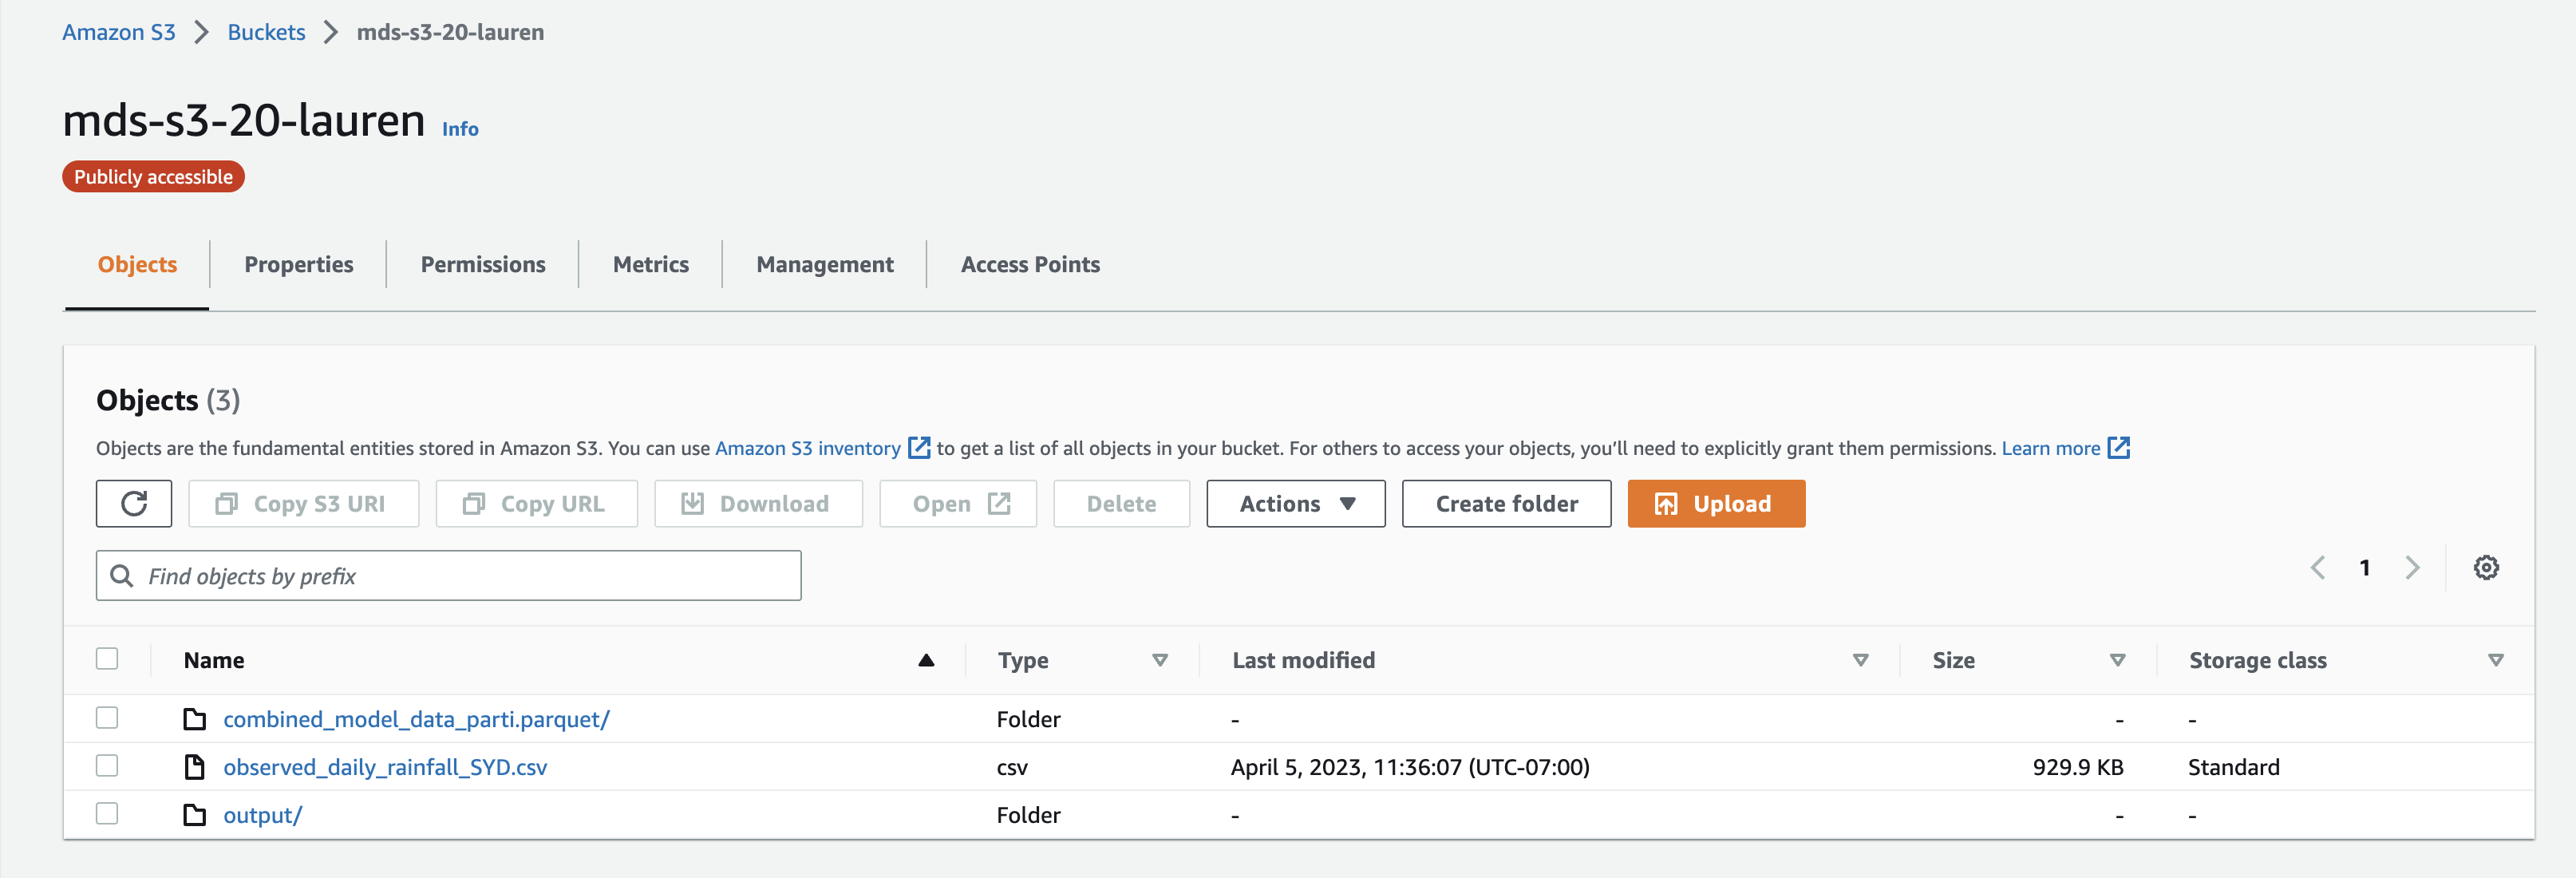

## 6. Wrangle the data in preparation for machine learning

In [6]:
os.environ["AWS_SHARED_CREDENTIALS_FILE"] = "../../../srv/keys/credentials"
os.environ["AWS_PROFILE"] = "default"

In [7]:
%%time

combined_df = pd.read_parquet(
    "s3://mds-s3-20-lauren/combined_model_data_parti.parquet")
combined_df

CPU times: user 7.3 s, sys: 5.29 s, total: 12.6 s
Wall time: 12 s


,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1,1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
2,1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
3,1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
4,1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2
...,...,...,...,...,...,...,...
62513858,2014-12-27 00:00:00,NaN,NaN,NaN,NaN,3.747200e-02,observed
62513859,2014-12-28 00:00:00,NaN,NaN,NaN,NaN,1.580613e-01,observed
62513860,2014-12-29 00:00:00,NaN,NaN,NaN,NaN,2.571914e-02,observed
62513861,2014-12-30 00:00:00,NaN,NaN,NaN,NaN,7.293899e-01,observed


In [8]:
syd_df = pd.read_csv("s3://mds-s3-20-lauren/observed_daily_rainfall_SYD.csv")
syd_df

,time,rain (mm/day)
0,1889-01-01,0.006612
1,1889-01-02,0.090422
2,1889-01-03,1.401452
3,1889-01-04,14.869798
4,1889-01-05,0.467628
...,...,...
46015,2014-12-27,0.037472
46016,2014-12-28,0.158061
46017,2014-12-29,0.025719
46018,2014-12-30,0.729390


In [9]:
filter_lat = combined_df[(combined_df['lat_min'] <= -33.86) & (combined_df['lat_max'] > -33.86)]
filter_latlon = filter_lat[(filter_lat['lon_min'] <= 151.21) & (filter_lat['lon_max'] > 151.21)]
filter_latlon = filter_latlon.drop(columns=['lat_min', 'lat_max', 'lon_min', 'lon_max'])
filter_latlon

,time,rain (mm/day),model
552240,1889-01-01 12:00:00,0.040427,ACCESS-CM2
552241,1889-01-02 12:00:00,0.073777,ACCESS-CM2
552242,1889-01-03 12:00:00,0.232656,ACCESS-CM2
552243,1889-01-04 12:00:00,0.911319,ACCESS-CM2
552244,1889-01-05 12:00:00,0.698013,ACCESS-CM2
...,...,...,...
60352298,2014-12-27 12:00:00,17.444923,TaiESM1
60352299,2014-12-28 12:00:00,1.569647,TaiESM1
60352300,2014-12-29 12:00:00,1.444630,TaiESM1
60352301,2014-12-30 12:00:00,0.716019,TaiESM1


In [10]:
syd_df['model'] = 'Observed'
syd_df

,time,rain (mm/day),model
0,1889-01-01,0.006612,Observed
1,1889-01-02,0.090422,Observed
2,1889-01-03,1.401452,Observed
3,1889-01-04,14.869798,Observed
4,1889-01-05,0.467628,Observed
...,...,...,...
46015,2014-12-27,0.037472,Observed
46016,2014-12-28,0.158061,Observed
46017,2014-12-29,0.025719,Observed
46018,2014-12-30,0.729390,Observed


In [11]:
ml_data_SYD = pd.concat([filter_latlon, syd_df])
ml_data_SYD['time'] = pd.to_datetime(ml_data_SYD['time']).dt.date
ml_data_SYD

,time,rain (mm/day),model
552240,1889-01-01,0.040427,ACCESS-CM2
552241,1889-01-02,0.073777,ACCESS-CM2
552242,1889-01-03,0.232656,ACCESS-CM2
552243,1889-01-04,0.911319,ACCESS-CM2
552244,1889-01-05,0.698013,ACCESS-CM2
...,...,...,...
46015,2014-12-27,0.037472,Observed
46016,2014-12-28,0.158061,Observed
46017,2014-12-29,0.025719,Observed
46018,2014-12-30,0.729390,Observed


In [12]:
ml_data_SYD.pivot(index='time', columns='model', values='rain (mm/day)')

model,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,Observed,SAM0-UNICON,TaiESM1
time,,,,,,,,,,,,,,,,,,,,,
1889-01-01,0.040427,1.814552,3.557934e+01,4.268112e+00,1.107466e-03,1.141054e+01,3.322009e-08,2.668800,1.321215,1.515293,...,4.244226e-13,1.390174e-13,6.537884e-05,3.445495e-06,1.576096e+01,4.759651e-05,2.451075,0.006612,0.221324,2.257933
1889-01-02,0.073777,0.303965,4.596520e+00,1.190141e+00,1.015323e-04,4.014984e+00,1.312700e+00,0.946211,2.788724,4.771375,...,4.409552e+00,1.222283e-01,1.049131e-13,4.791993e-09,3.675510e-01,4.350863e-01,0.477231,0.090422,3.757179,2.287381
1889-01-03,0.232656,0.019976,5.927467e+00,1.003845e-09,1.760345e-05,9.660565e+00,9.103720e+00,0.431999,0.003672,4.233980,...,2.269300e-01,3.762301e-01,9.758706e-14,6.912302e-01,1.562869e-01,9.561101e+00,0.023083,1.401452,0.253357,1.199909
1889-01-04,0.911319,13.623777,8.029624e+00,8.225225e-02,1.808932e-01,3.951528e+00,1.317160e+01,0.368693,0.013578,15.252495,...,2.344586e-02,4.214019e-01,7.060915e-03,3.835721e-02,2.472226e-07,5.301038e-01,0.002699,14.869798,2.185454,2.106737
1889-01-05,0.698013,0.021048,2.132686e+00,2.496841e+00,4.708019e-09,2.766362e+00,1.822940e+01,0.339267,0.002468,11.920356,...,4.270161e-13,1.879692e-01,4.504985e+00,3.506923e-07,1.949792e-13,1.460928e-10,0.001026,0.467628,2.766507,1.763335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,0.033748,0.123476,1.451179e+00,3.852845e+01,2.061717e-03,8.179260e-09,1.171263e-02,0.090786,59.895053,5.071783,...,4.726998e-13,1.326889e-01,1.827857e+00,6.912632e-03,2.171327e-03,1.620489e+00,2.084252,0.037472,0.868046,17.444923
2014-12-28,0.094198,2.645496,4.249335e+01,5.833801e-01,5.939502e-09,8.146937e-01,4.938899e-01,0.000000,0.512632,1.578188,...,4.609420e-13,1.644482e+00,7.242920e-01,2.836752e-03,1.344768e+01,2.391159e+00,1.644527,0.158061,0.782258,1.569647
2014-12-29,0.005964,3.041667,2.898325e+00,9.359547e-02,2.000051e-08,2.532205e-01,1.306046e+00,0.000002,37.169669,1.565885,...,2.016156e+01,1.506439e+00,1.049481e-01,8.137182e+00,2.547820e+01,1.987695e-12,0.205036,0.025719,2.140723,1.444630


In [13]:
ml_data_SYD.to_csv('s3://mds-s3-20-lauren/output/ml_data_SYD.csv')